In [1]:
# Install kagglehub if not already installed
!pip install kagglehub

import kagglehub
import shutil
import os

path = kagglehub.dataset_download("madalagopichand/nyc-green-yellow-taxi-trip-records")
print("Path to dataset files:", path)

root = "/home/xuy001/xuy001/Data"
os.makedirs(root, exist_ok=True)
shutil.move(path, root)
print("Relocated path:", root)

Path to dataset files: /home/xuy001/.cache/kagglehub/datasets/madalagopichand/nyc-green-yellow-taxi-trip-records/versions/1
Relocated path: /home/xuy001/xuy001/Data


In [57]:
import os, pickle, glob
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from functools import reduce
from pyspark.sql import *
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
os.listdir(root)

['green', 'taxi_zone_lookup.csv', 'yellow']

In [4]:
f"{root}/yellow/*/*.parquet"

'/home/xuy001/xuy001/Data/yellow/*/*.parquet'

In [5]:
f"{root}/green/*/*.parquet"

'/home/xuy001/xuy001/Data/green/*/*.parquet'

In [6]:
spark = SparkSession.builder \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config('spark.executor.instances', 9) \
    .getOrCreate()

### Load Data

In [7]:
def load_dataframes(taxi_color = "yellow"):
    paths = glob.glob(f"{root}/{taxi_color}/*/*.parquet")
    
    dataframes = []
    for path in paths:
        year = os.path.basename(os.path.dirname(path))
        
        df = spark.read.parquet(path)
        
        if "congestion_surcharge" in df.columns:
            df = df.withColumn("congestion_surcharge", df["congestion_surcharge"].cast("double"))
        if "airport_fee" in df.columns:
            df = df.withColumn("airport_fee", df["airport_fee"].cast("double"))
        df = df.withColumn("year", F.lit(year)) \
                .withColumn("taxi_color", F.lit(taxi_color))
        dataframes.append(df)
    combined_df = reduce(lambda a, b: a.unionByName(b, allowMissingColumns=True), dataframes)
    return combined_df

#### Yellow Taxi Data

In [8]:
yellow_data = load_dataframes("yellow")
yellow_data.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- year: string (nullable = false)
 |-- taxi_color: string (nullable = false)



In [9]:
print(f"Yellow data has {yellow_data.count()} observations.")

Yellow data has 918278217 observations.


#### Green Taxi Data

In [10]:
green_data = load_dataframes("green")
green_data.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- lpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- lpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- year: string (nullable = false)
 |-- taxi_color: string (nullable = false)



In [11]:
print(f"Green data has {green_data.count()} observations.")

Green data has 83484688 observations.


#### Combine Yellow Taxi and Green Taxi Data

Since yellow taxi data has extra column `airport_fee`, and green taxi data has extra columns `trip_type` and `ehail_fee`, we will drop these columns before analysis. Additionally, to unify the schema, we will rename `tpep_pickup_datetime` in yellow data and `lpep_pickup_datetime` in green to `pickup_datetime`. Similarly, `tpep_dropoff_datetime` and `lpep_dropoff_datetime` will be renamed to `dropoff_datetime`.

In [12]:
yellow_cleaned = yellow_data.drop("airport_fee") \
    .withColumnRenamed("tpep_pickup_datetime", "pickup_datetime") \
    .withColumnRenamed("tpep_dropoff_datetime", "dropoff_datetime")

green_cleaned = green_data.drop("trip_type", "ehail_fee") \
    .withColumnRenamed("lpep_pickup_datetime", "pickup_datetime") \
    .withColumnRenamed("lpep_dropoff_datetime", "dropoff_datetime")

taxi_all = yellow_cleaned.unionByName(green_cleaned)

In [13]:
print(f"All taxi data has {taxi_all.count()} observations.")

All taxi data has 1001762905 observations.


In [14]:
# Sample of data
taxi_all.show(10, truncate=False)

+--------+-------------------+-------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----+----------+
|VendorID|pickup_datetime    |dropoff_datetime   |passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|year|taxi_color|
+--------+-------------------+-------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----+----------+
|1       |2017-11-01 00:01:48|2017-11-01 00:03:47|1.0            |0.4          |1.0       |N                 |151         |151         |2.0         |3.5        |0.5  |0.5    |0.0      

In [15]:
taxi_all.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- year: string (nullable = false)
 |-- taxi_color: string (nullable = false)



### Statistics

#### Check outliers of columns

In [16]:
taxi_all.select(
    F.col("passenger_count"),
    F.col("trip_distance")
).describe().show()

+-------+-----------------+-----------------+
|summary|  passenger_count|    trip_distance|
+-------+-----------------+-----------------+
|  count|        990317379|       1001762905|
|   mean|1.581164489490394|6.842751630017696|
| stddev|1.232428148386412|7178.487649317095|
|    min|              0.0|    -4.08401244E7|
|    max|            208.0|    1.346190631E8|
+-------+-----------------+-----------------+



In [17]:
def get_iqr_bounds(column):
    q1, q3 = taxi_all.approxQuantile(column, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(f"IQR bounds: {lower_bound:.2f} to {upper_bound:.2f}")
    return lower_bound, upper_bound

In [18]:
passenger_count_lower, passenger_count_upper = get_iqr_bounds("passenger_count")

IQR bounds: -0.50 to 3.50


In [19]:
trip_distance_lower, trip_distance_upper = get_iqr_bounds("trip_distance")

IQR bounds: -2.30 to 6.50


#### Remove outliers

As we can see from the stats and IQR bounds, there's at least one outlier with **208** as `passenger_count` in the data. Also, there's at least one outlier with **-4.08401244E7** as `trip_distance` in the data. We need to filter out data points outside of the IQR bounds. Additionally, in reality, there shouldn't be negative `passenger_count` and negative `trip_distance`, so, we need to remove them. Note: we would keep the null value at this point and impute data later.

In [20]:
no_outliers_taxi_all = taxi_all.filter(
    (((F.col("passenger_count") >= 0) & (F.col("passenger_count") <= passenger_count_upper)) |
     F.col("passenger_count").isNull()) &
    (((F.col("trip_distance") >= 0) & (F.col("trip_distance") <= trip_distance_upper)) |
     F.col("trip_distance").isNull())
)

In [21]:
no_outliers_taxi_all.count()

814271959

#### Check for null values

In [22]:
def df_info(df):
    total = df.count()
    null_counts = df.select([
        F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns
    ]).collect()[0].asDict()

    print("Total rows:", total)
    print(f"{'Column':30} {'Nulls':>10}")
    print("-" * 60)
    for field in df.schema.fields:
        col_name = field.name
        nulls = null_counts.get(col_name, 0)
        print(f"{col_name:30} {nulls:10}")

In [23]:
df_info(no_outliers_taxi_all)

Total rows: 814271959
Column                              Nulls
------------------------------------------------------------
VendorID                                0
pickup_datetime                         0
dropoff_datetime                        0
passenger_count                   8524610
trip_distance                           0
RatecodeID                        8524610
store_and_fwd_flag               44270473
PULocationID                            0
DOLocationID                            0
payment_type                      1086589
fare_amount                             0
extra                                   0
mta_tax                                 0
tip_amount                              0
tolls_amount                            0
improvement_surcharge            54707863
total_amount                            0
congestion_surcharge            603645653
year                                    0
taxi_color                              0


As we can see, there are missing values in columns `passenger_count`, `RatecodeID`, `store_and_fwd_flag`, `payment_type`, `improvement_surcharge`, and `congestion_surcharge`, we are interested in using `passenger_count` in our analysis. We would fill with mode based on `PULocationID` and day of week extracted from `pickup_datetime`. 

In [24]:
passenger_counts = no_outliers_taxi_all.groupBy("passenger_count") \
    .count() \
    .orderBy("passenger_count") \
    .collect()

labels = [str(row["passenger_count"]) for row in passenger_counts]
counts = [row["count"] for row in passenger_counts]

In [25]:
passenger_counts

[Row(passenger_count=None, count=8524610),
 Row(passenger_count=0.0, count=5152707),
 Row(passenger_count=1.0, count=644302151),
 Row(passenger_count=2.0, count=121576003),
 Row(passenger_count=3.0, count=34716488)]

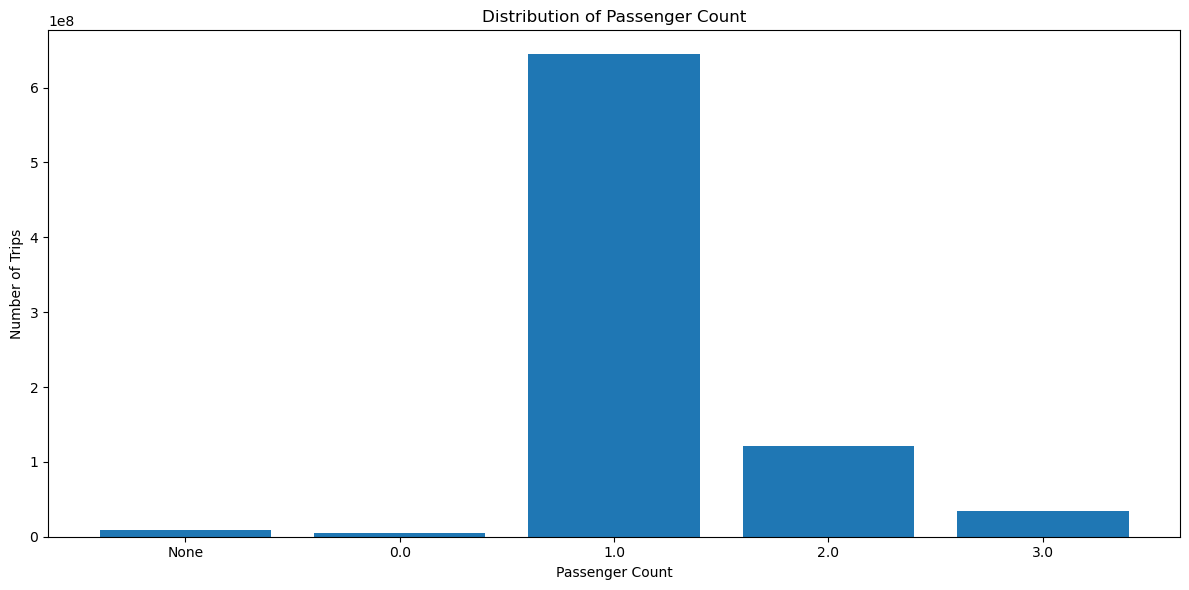

In [26]:
plt.figure(figsize=(12, 6))
plt.bar(labels, counts, width=0.8)
plt.xlabel("Passenger Count")
plt.ylabel("Number of Trips")
plt.title("Distribution of Passenger Count")
plt.tight_layout()
plt.show()

In [27]:
no_outliers_taxi_all = no_outliers_taxi_all.withColumn("pickup_day_num", F.dayofweek("pickup_datetime"))
no_outliers_taxi_all.createOrReplaceTempView("no_outliers")

In [28]:
cleaned_df = spark.sql("""
with passenger_count_mode as (
    select PULocationID, pickup_day_num, passenger_count
    from (
        select PULocationID, 
               pickup_day_num, 
               passenger_count,
               count(*) as freq,
               row_number() over (
                   partition by PULocationID, pickup_day_num 
                   order by count(*) desc
               ) as rn
        from no_outliers
        where passenger_count is not null
        group by PULocationID, pickup_day_num, passenger_count
    ) t
    where rn = 1
)
select a.*,
   case 
       when a.passenger_count is null then b.passenger_count
       else a.passenger_count
   end as passenger_count_filled
from no_outliers a
left join passenger_count_mode b
on a.PULocationID = b.PULocationID and a.pickup_day_num = b.pickup_day_num;
""")
cleaned_df = cleaned_df.drop("passenger_count").withColumnRenamed("passenger_count_filled", "passenger_count")

In [29]:
passenger_counts_after = cleaned_df.groupBy("passenger_count") \
    .count() \
    .orderBy("passenger_count") \
    .collect()

labels = [str(row["passenger_count"]) for row in passenger_counts_after]
counts = [row["count"] for row in passenger_counts_after]

In [30]:
passenger_counts_after

[Row(passenger_count=0.0, count=5152707),
 Row(passenger_count=1.0, count=652826761),
 Row(passenger_count=2.0, count=121576003),
 Row(passenger_count=3.0, count=34716488)]

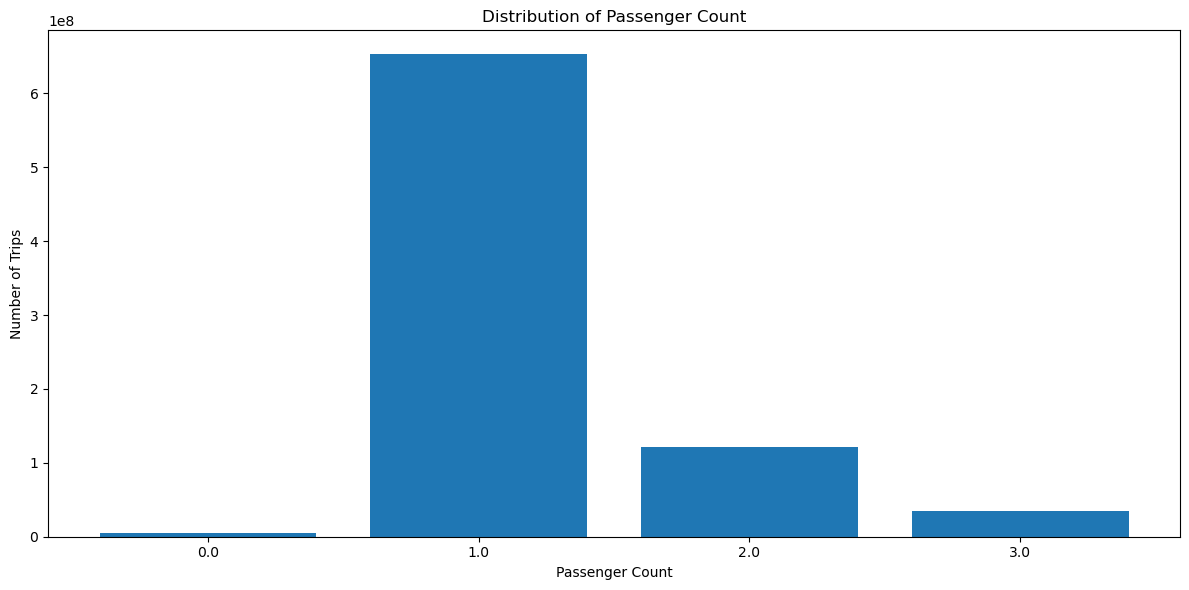

In [31]:
plt.figure(figsize=(12, 6))
plt.bar(labels, counts, width=0.8)
plt.xlabel("Passenger Count")
plt.ylabel("Number of Trips")
plt.title("Distribution of Passenger Count")
plt.tight_layout()
plt.show()

The `passenger_count` column has now been imputed using the mode (most frequent value) calculated within each group, where groups are defined by the combination of pickup weekday (`pickup_day_num`) and pickup location (`PULocationID`).

### Plots

#### Pickup Locations (PULocationID) Count

In [32]:
pickup_location_count = cleaned_df.groupBy("PULocationID") \
    .count() \
    .orderBy("count", ascending=False) \
    .collect()

labels = [str(row["PULocationID"]) for row in pickup_location_count]
counts = [row["count"] for row in pickup_location_count]

In [33]:
pickup_location_count

[Row(PULocationID=237, count=32560175),
 Row(PULocationID=236, count=29431953),
 Row(PULocationID=161, count=28982975),
 Row(PULocationID=186, count=26403298),
 Row(PULocationID=162, count=26182875),
 Row(PULocationID=170, count=24927263),
 Row(PULocationID=234, count=24810011),
 Row(PULocationID=230, count=24015746),
 Row(PULocationID=48, count=23862220),
 Row(PULocationID=142, count=23366442),
 Row(PULocationID=79, count=23119959),
 Row(PULocationID=163, count=20767963),
 Row(PULocationID=239, count=20246077),
 Row(PULocationID=68, count=19555078),
 Row(PULocationID=107, count=19405729),
 Row(PULocationID=141, count=18815495),
 Row(PULocationID=164, count=18394909),
 Row(PULocationID=249, count=16826208),
 Row(PULocationID=229, count=15233764),
 Row(PULocationID=238, count=14959613),
 Row(PULocationID=90, count=14761080),
 Row(PULocationID=100, count=14455489),
 Row(PULocationID=263, count=14303251),
 Row(PULocationID=140, count=13861461),
 Row(PULocationID=231, count=13396808),
 Row

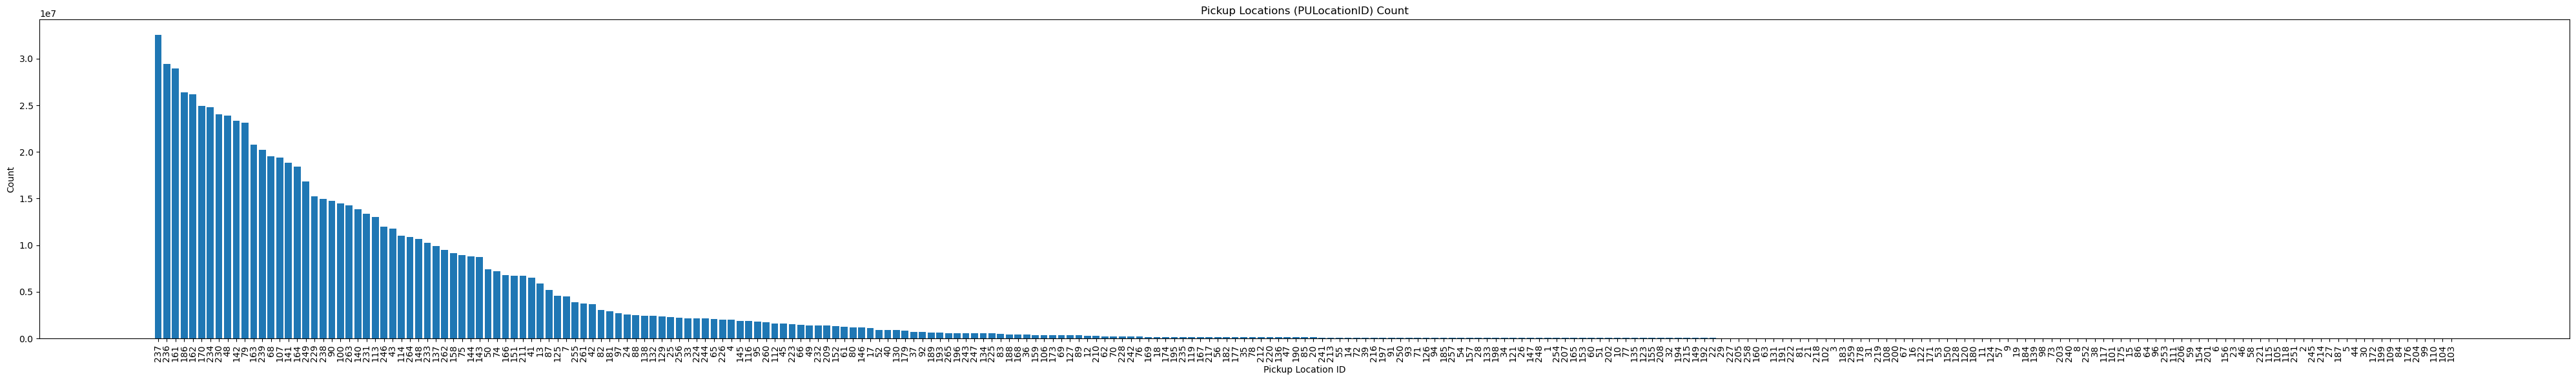

In [34]:
plt.figure(figsize=(40, 6))
plt.bar(labels, counts)
plt.xlabel("Pickup Location ID")
plt.ylabel("Count")
plt.title("Pickup Locations (PULocationID) Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Drop-off Locations (DOLocationID) Count

In [35]:
dropoff_location_count = cleaned_df.groupBy("DOLocationID") \
    .count() \
    .orderBy("count", ascending=False) \
    .collect()

labels = [str(row["DOLocationID"]) for row in dropoff_location_count]
counts = [row["count"] for row in dropoff_location_count]

In [36]:
dropoff_location_count

[Row(DOLocationID=236, count=31016428),
 Row(DOLocationID=161, count=29568217),
 Row(DOLocationID=237, count=29224033),
 Row(DOLocationID=170, count=25082891),
 Row(DOLocationID=162, count=23469650),
 Row(DOLocationID=230, count=22799159),
 Row(DOLocationID=234, count=22017123),
 Row(DOLocationID=48, count=21170096),
 Row(DOLocationID=186, count=21123320),
 Row(DOLocationID=142, count=21117457),
 Row(DOLocationID=239, count=19937479),
 Row(DOLocationID=79, count=19681111),
 Row(DOLocationID=141, count=19375388),
 Row(DOLocationID=163, count=18941638),
 Row(DOLocationID=68, count=18768909),
 Row(DOLocationID=107, count=17050768),
 Row(DOLocationID=238, count=16697627),
 Row(DOLocationID=164, count=16651964),
 Row(DOLocationID=246, count=15256685),
 Row(DOLocationID=263, count=15208869),
 Row(DOLocationID=140, count=14660978),
 Row(DOLocationID=229, count=14417937),
 Row(DOLocationID=249, count=13893075),
 Row(DOLocationID=231, count=13037052),
 Row(DOLocationID=90, count=12009036),
 Row

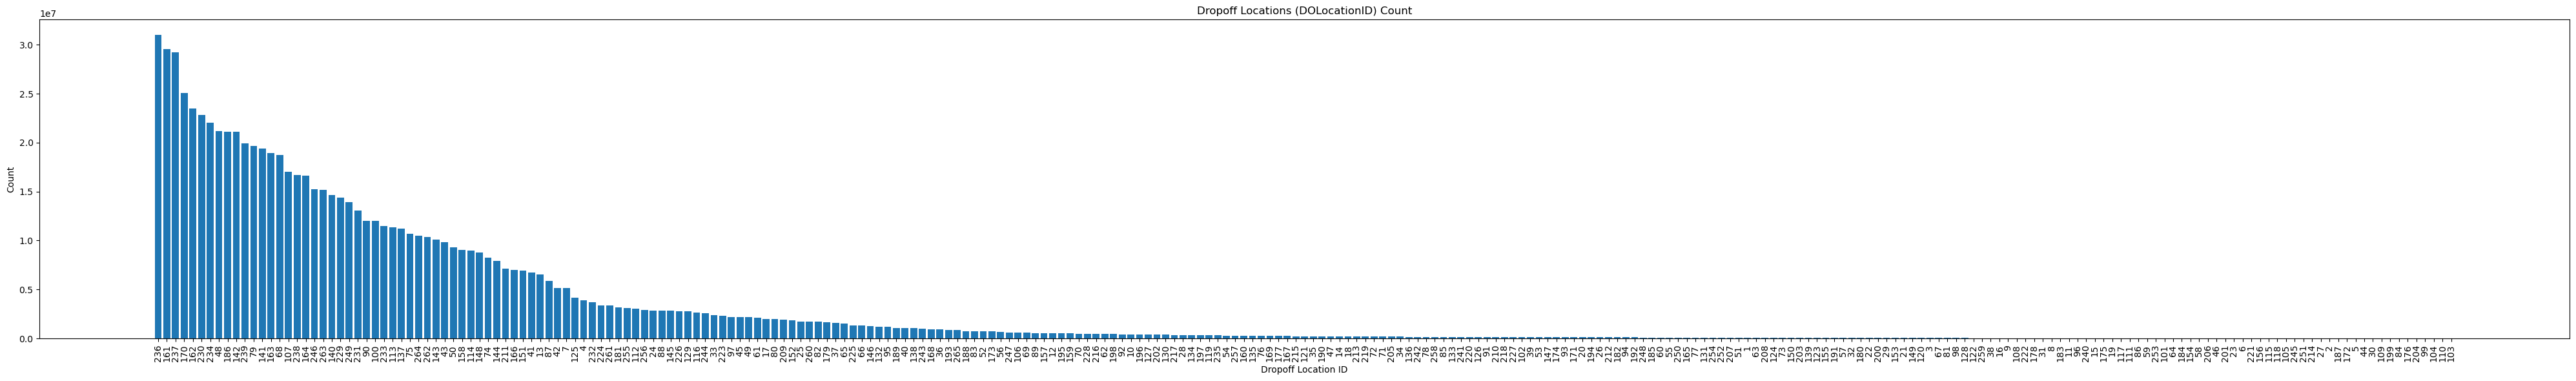

In [37]:
plt.figure(figsize=(40, 6))
plt.bar(labels, counts)
plt.xlabel("Dropoff Location ID")
plt.ylabel("Count")
plt.title("Dropoff Locations (DOLocationID) Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Pick-up locations VS Drop-off locations

In [38]:
# Sample 0.1% of data
sampled = cleaned_df.select("PULocationID", "DOLocationID") \
    .dropna() \
    .sample(fraction=0.001, seed=42) \
    .collect()

x = [row["PULocationID"] for row in sampled]
y = [row["DOLocationID"] for row in sampled]

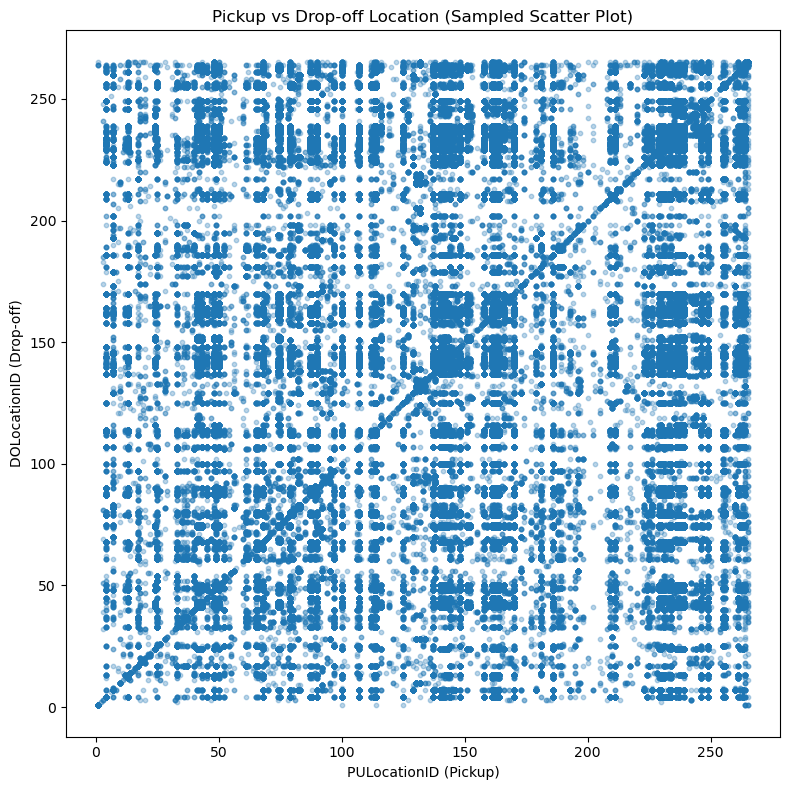

In [39]:
plt.figure(figsize=(8, 8))
plt.scatter(x, y, alpha=0.3, s=10)
plt.xlabel("PULocationID (Pickup)")
plt.ylabel("DOLocationID (Drop-off)")
plt.title("Pickup vs Drop-off Location (Sampled Scatter Plot)")
plt.tight_layout()
plt.show()

#### Pickup day of week VS Drop-off locations

In [42]:
dropoff_day_location = cleaned_df.groupBy("pickup_day_num", "DOLocationID") \
    .count() \
    .orderBy("pickup_day_num", "count", ascending=False) \
    .collect()

In [50]:
# sample
dropoff_day_location[:10]

[Row(pickup_day_num=7, DOLocationID=79, count=4204954),
 Row(pickup_day_num=7, DOLocationID=48, count=3709553),
 Row(pickup_day_num=7, DOLocationID=236, count=3697019),
 Row(pickup_day_num=7, DOLocationID=237, count=3554959),
 Row(pickup_day_num=7, DOLocationID=170, count=3453028),
 Row(pickup_day_num=7, DOLocationID=230, count=3333447),
 Row(pickup_day_num=7, DOLocationID=142, count=3293645),
 Row(pickup_day_num=7, DOLocationID=186, count=3289647),
 Row(pickup_day_num=7, DOLocationID=234, count=3169941),
 Row(pickup_day_num=7, DOLocationID=68, count=3122941)]

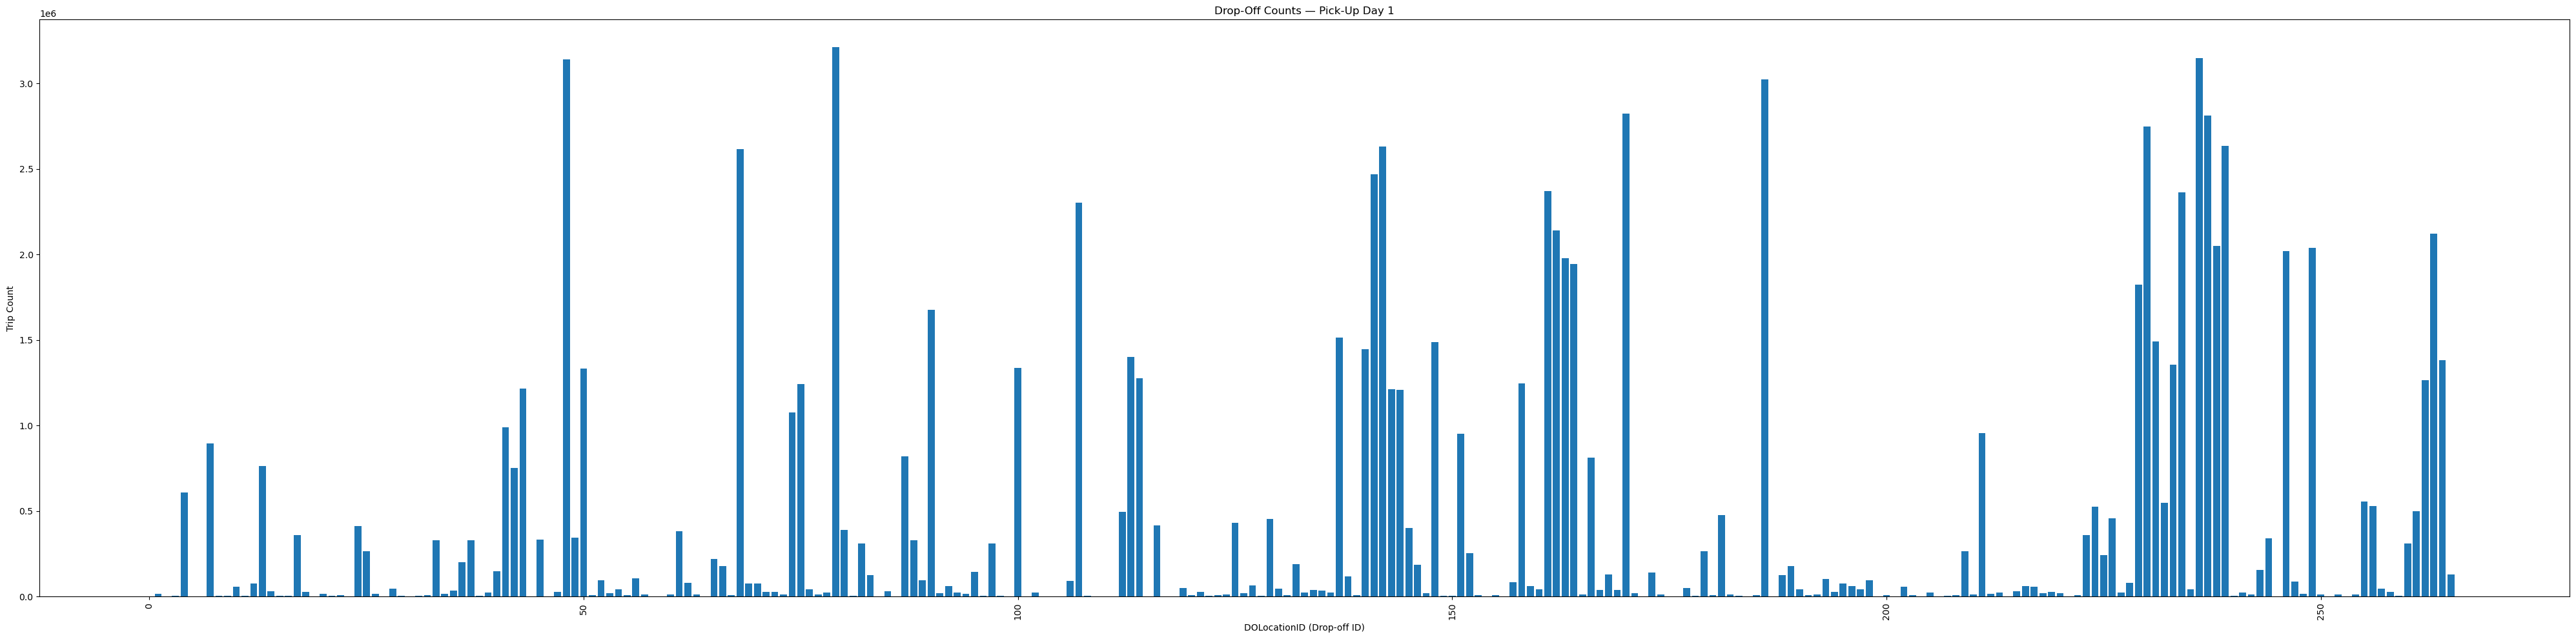

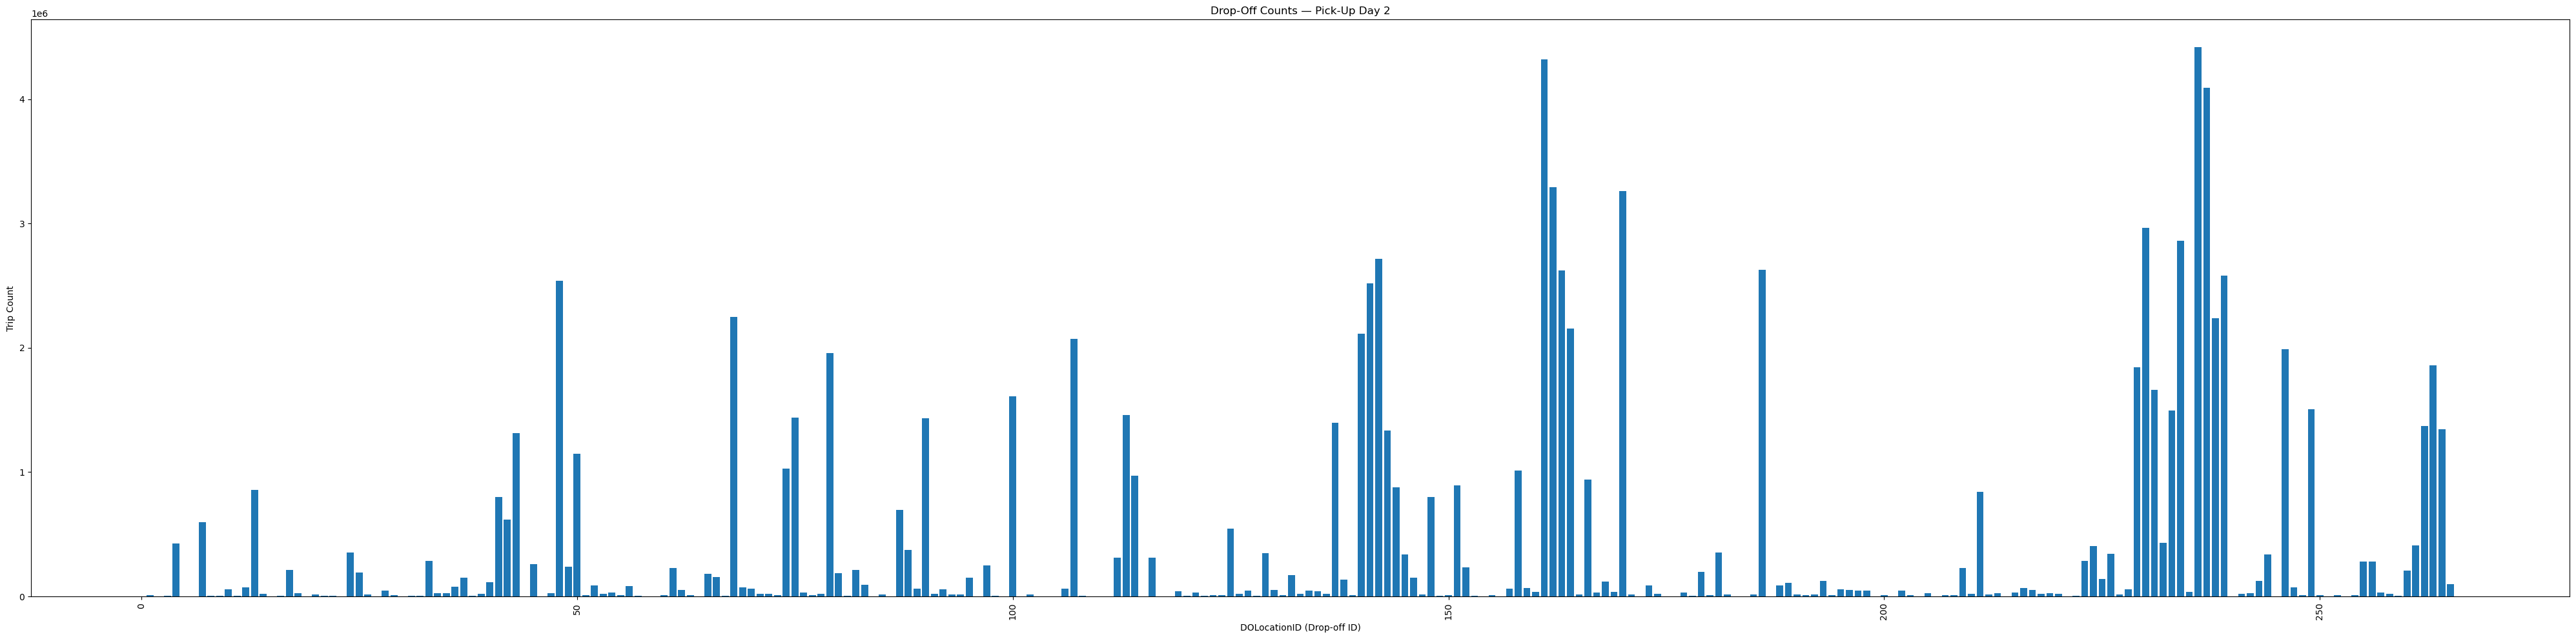

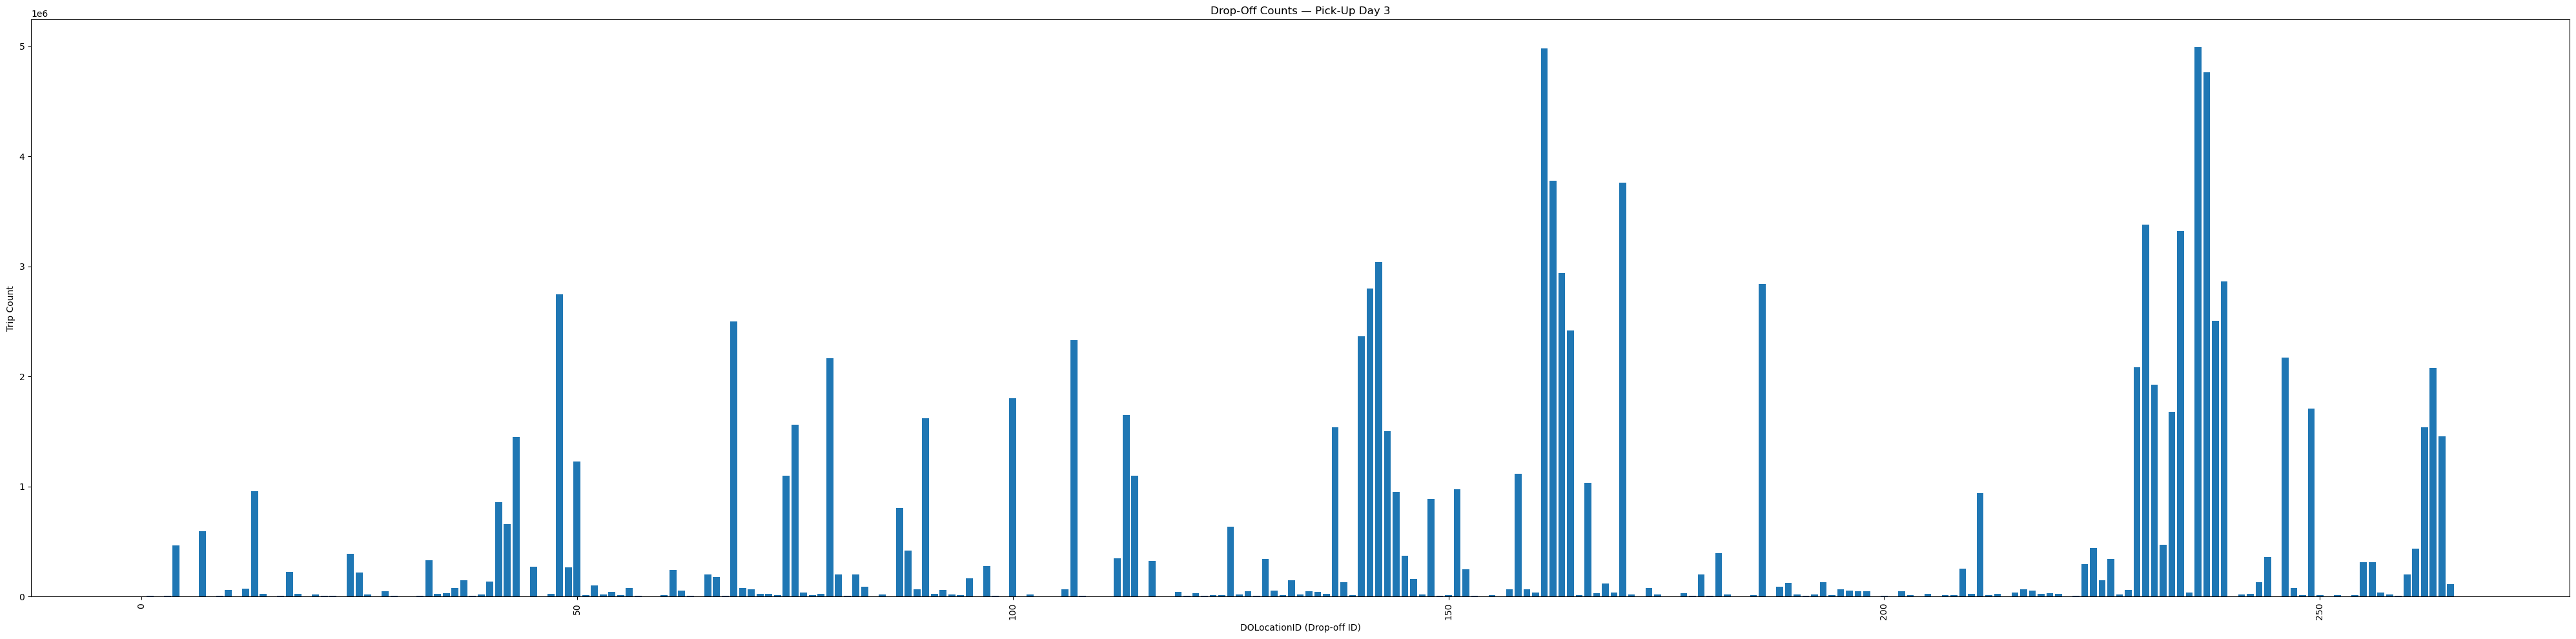

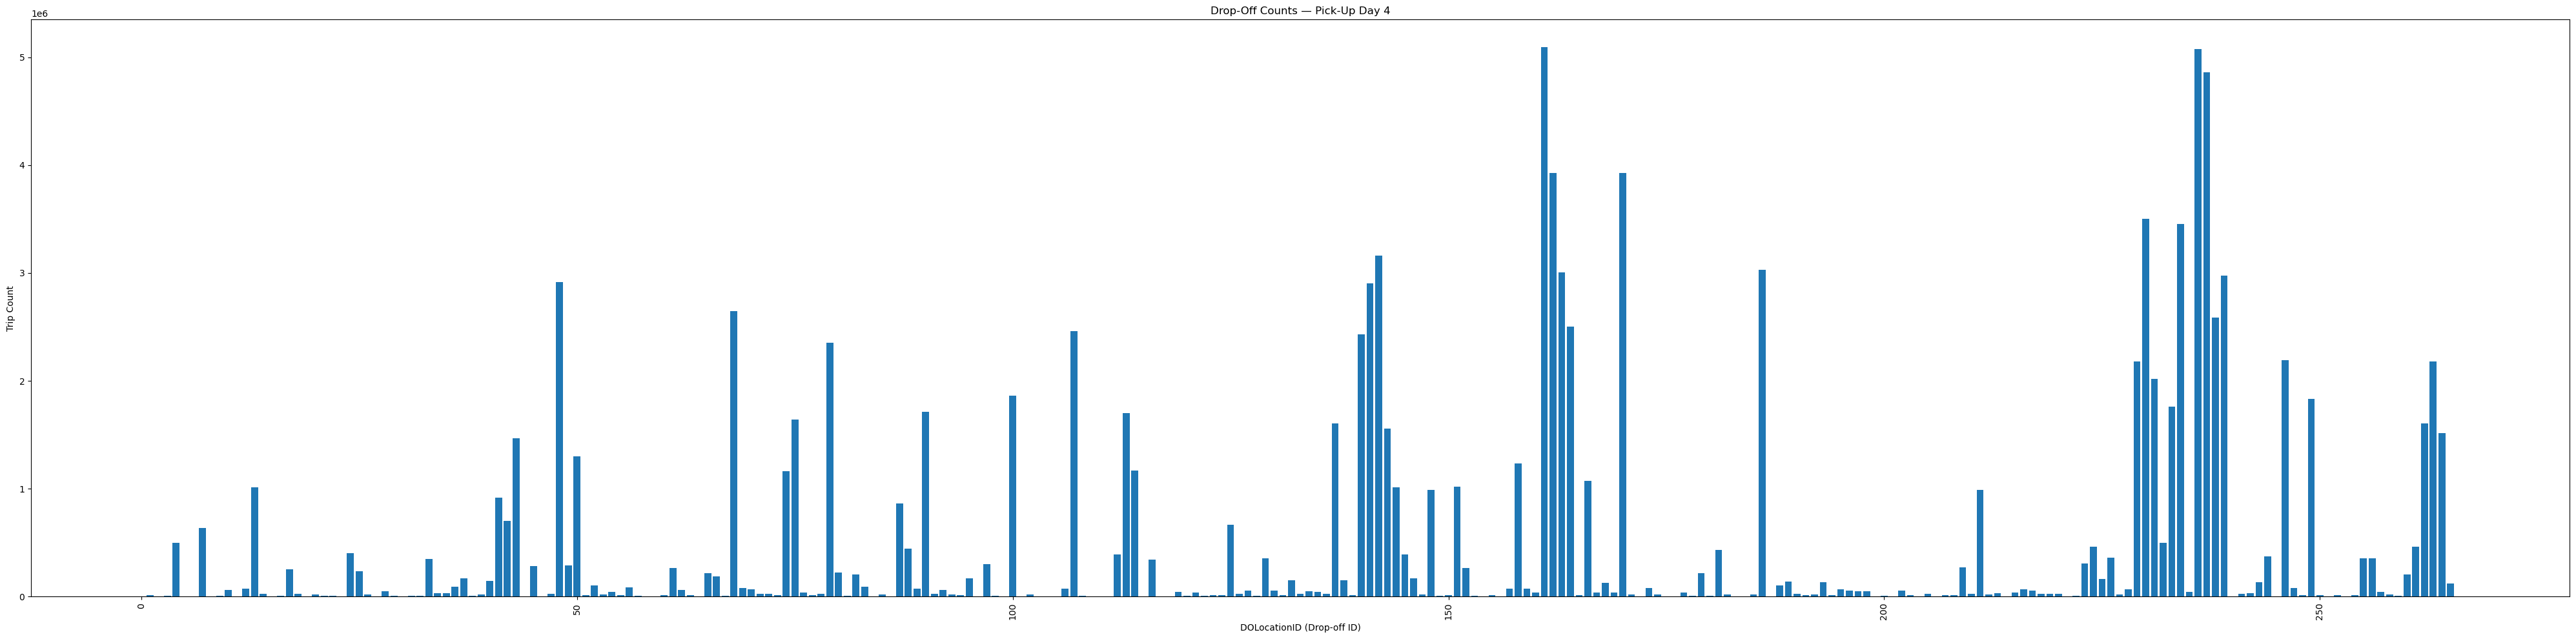

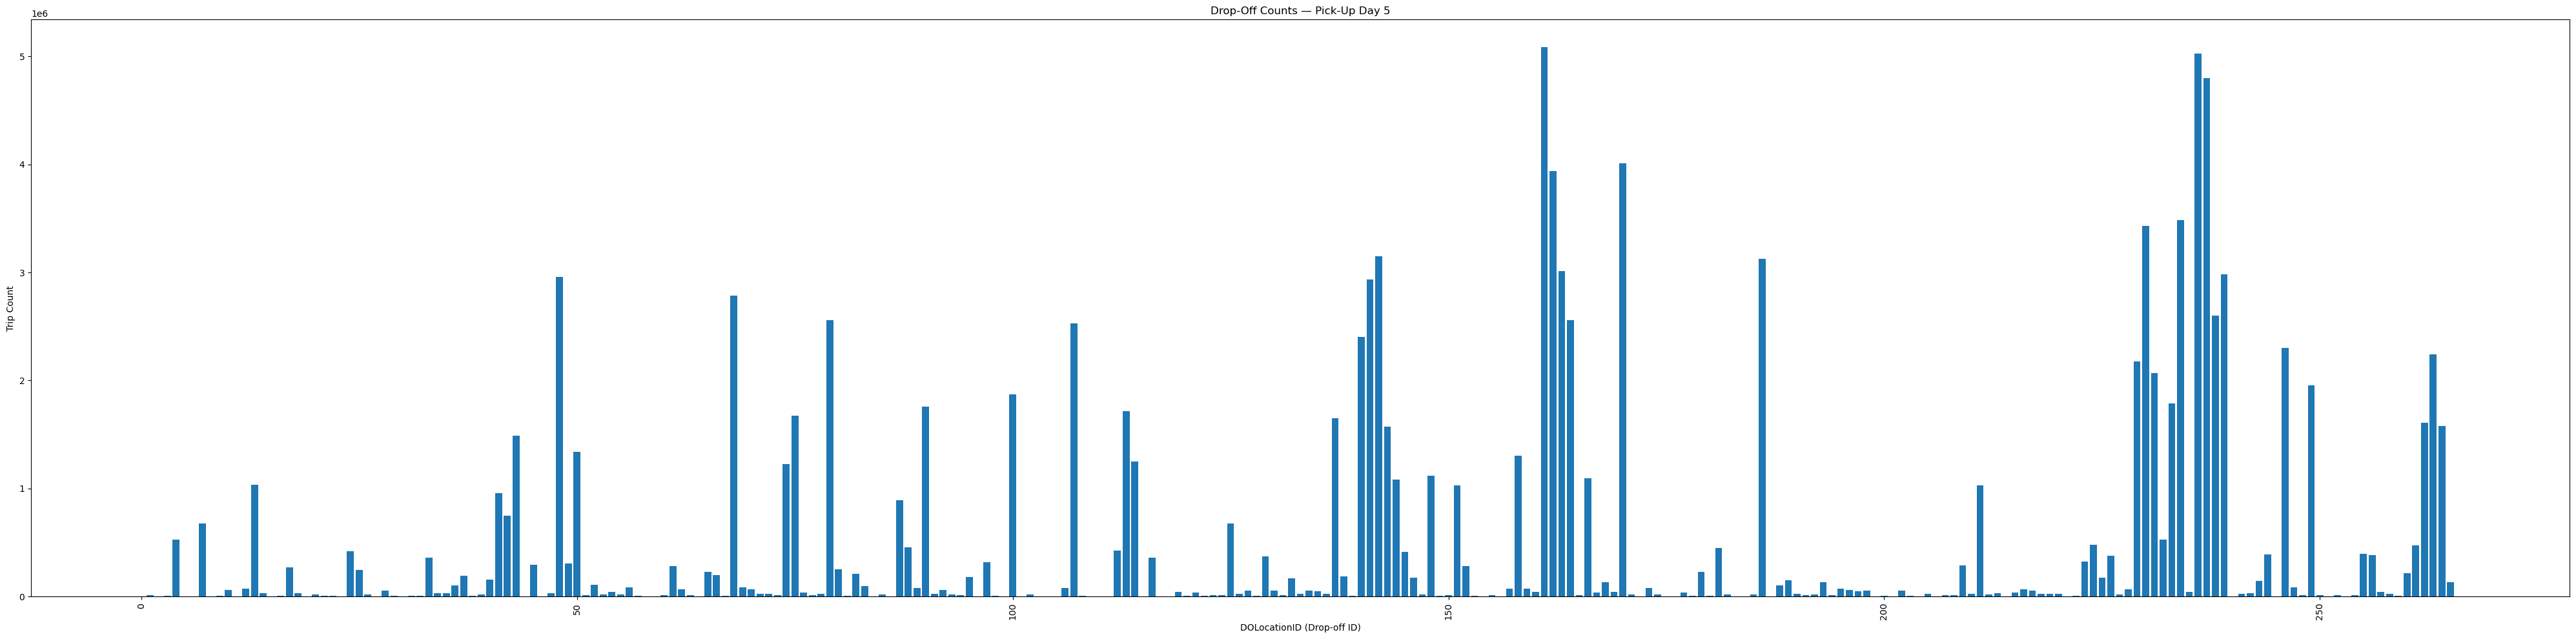

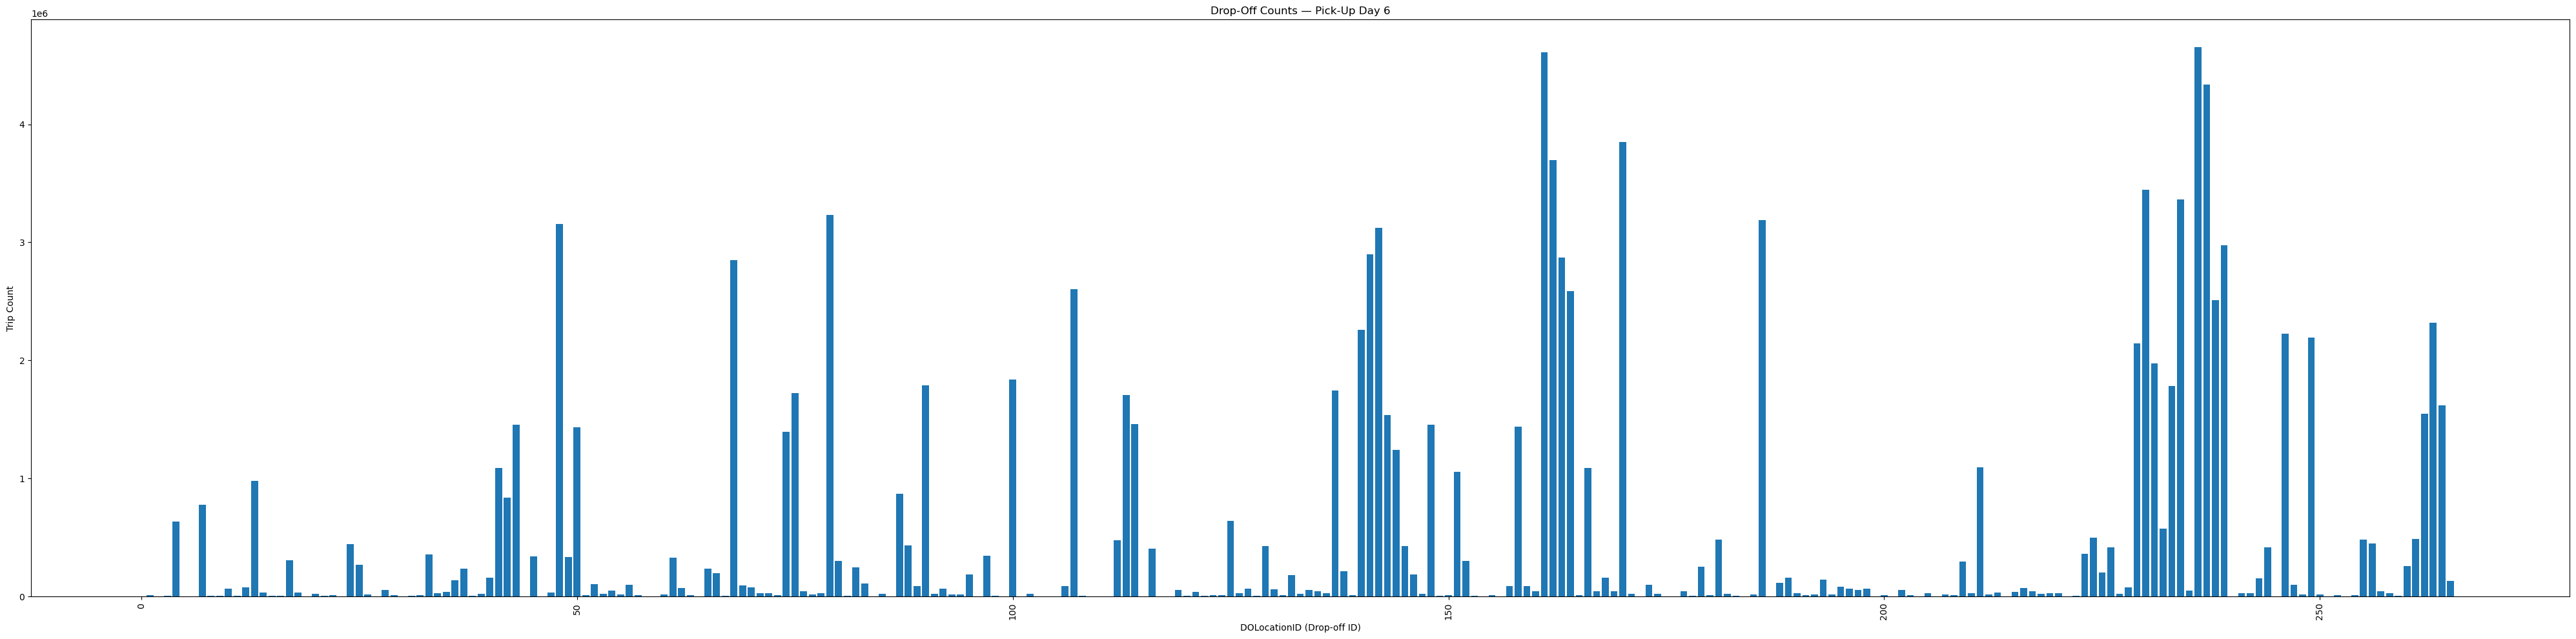

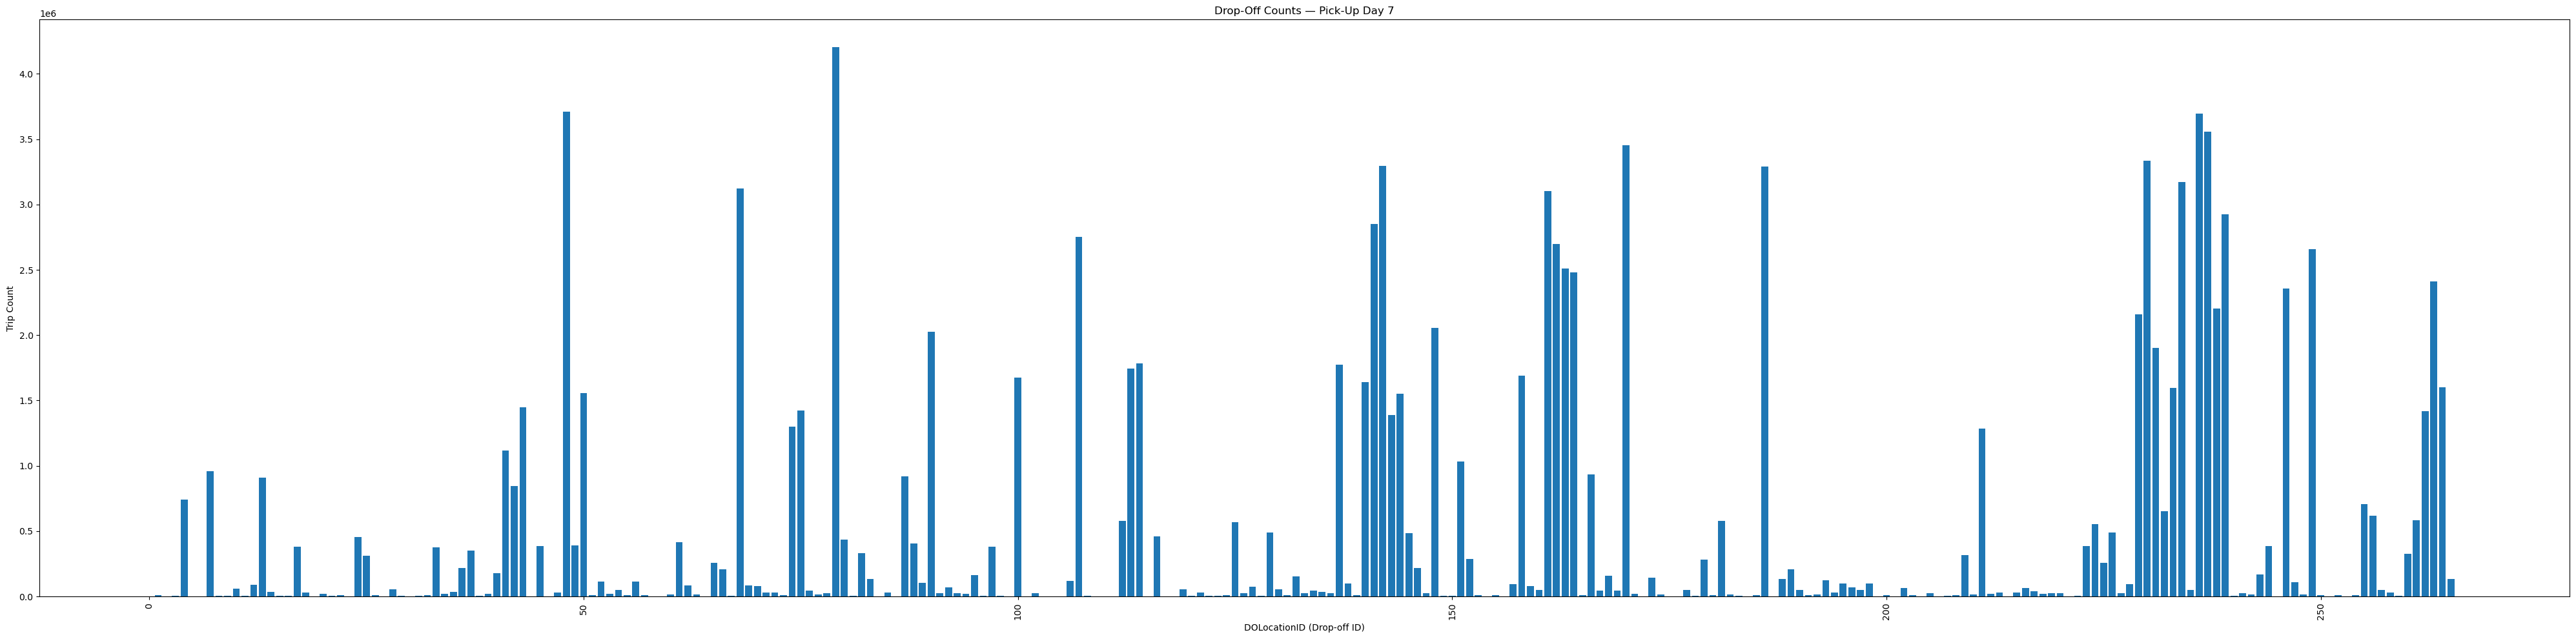

In [64]:
dropoff_day_location_dict = defaultdict(lambda: defaultdict(int))

for r in dropoff_day_location:
    dow = r["pickup_day_num"]
    dol = r["DOLocationID"]
    dropoff_day_location_dict[dow][dol] += r["count"]
    
for day in range(1, 8): 
    loc_counts = dropoff_day_location_dict.get(day, {})
    sorted_pairs = sorted(loc_counts.items(), key=lambda x: x[1], reverse=True)
    labels, counts = zip(*sorted_pairs)

    plt.figure(figsize=(40, 10))
    plt.bar(labels, counts)
    plt.xlabel("DOLocationID (Drop-off ID)")
    plt.ylabel("Trip Count")
    plt.title(f"Drop-Off Counts — Pick-Up Day {day}") 
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()